## Dagger

This notebook implements dagger. Dagger recongizes that a strict cloning approach will result in your policy going to states that the expert may not have encountered. TO overcome this, dagger "collects the states your policy wondered into during its evaluation runs, and ask the expert what it would have done in the same state. Then you augment your training dataset with these new state-action pairs. This gives your policy a better chance of reaching good performance early on. Practically this means instantiating the expert policy and calling policy_fn with the states encountered by your policy during evaluation, and adding those new state-action pairs to the training dataset. You can get fancy with how you combine these, by slowly phasing out the expert only data, but just adding them to the training set is valid. This should improve the training substantially on some of the environments." From - https://www.reddit.com/r/berkeleydeeprlcourse/comments/5suhf3/hw_1_results_and_lessons_learned/ddpv8dq/
For more background on dagger, just google.  Here are some slides from the Berkeley course - http://rll.berkeley.edu/deeprlcourse/docs/2015.10.5.dagger.pdf

The code in this notebook is largely based off code posted at https://github.com/ghostFaceKillah/deep-rl-berkeley/tree/master/hw1 

In [6]:
import gym
import load_policy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import tensorflow as tf
import tf_util
import tqdm

from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers import Dense, Lambda
from keras.optimizers import Adam

%matplotlib inline


In [2]:
env_name = "Reacher-v1"

In [3]:
def load_policy_fn(env_name):
    print('Gathering expert data')
    print('loading and building expert policy')
    policy_fname = 'experts/{}.pkl'.format(env_name)
    policy_fn = load_policy.load_policy(policy_fname)
    print('loaded and built')
    return policy_fn


def get_batch_of_full_expert_data(policy_fn, env, render=False):
    with tf.Session():
        tf_util.initialize()

        max_steps = env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')

        returns = []
        observations = []
        actions = []
        steps_numbers = []

        obs = env.reset()
        done = False
        totalr = 0.
        steps = 0
        while not done:
            action = policy_fn(obs[None,:])
            observations.append(obs)
            actions.append(action)
            obs, r, done, _ = env.step(action)
            totalr += r
            steps += 1
            if render:
                env.render()
            if steps >= max_steps:
                break
        steps_numbers.append(steps)
        returns.append(totalr)

        expert_data = {'observations': np.array(observations),
                       'actions': np.array(actions),
                       'returns': np.array(returns),
                       'steps': np.array(steps_numbers)}

    return expert_data


def test_run_our_model(model, env, rollouts=20, render=False):
    max_steps = env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')

    returns = []
    observations = []
    actions = []
    steps_numbers = []

    for i in tqdm.tqdm(range(rollouts)):
        obs = env.reset()
        done = False
        totalr = 0.
        steps = 0
        while not done:
            action = model.predict(obs[None, :])
            observations.append(obs)
            actions.append(action)
            obs, r, done, _ = env.step(action)
            totalr += r
            steps += 1
            if render:
                env.render()
            if steps >= max_steps:
                break
        steps_numbers.append(steps)
        returns.append(totalr)

    return {'observations': np.array(observations),
            'actions': np.array(actions),
            'returns': np.array(returns),
            'steps': np.array(steps_numbers)}



def run_expert_on_observations(observations, policy_fn):
    with tf.Session():
        tf_util.initialize()

        actions = []

        for obs in observations:
            action = policy_fn(obs[None,:])
            actions.append(action)

    return np.array(actions)


def build_net(data, env):
    mean = np.mean(data['observations'], axis=0)
    std = np.std(data['observations'], axis=0) + 1e-6

    observations_dim = env.observation_space.shape[0]
    actions_dim = env.action_space.shape[0]

    model = Sequential([
        Lambda(lambda x: (x - mean) / std,
               batch_input_shape=(None, observations_dim)),
        Dense(64, activation='tanh'),
        Dense(64, activation='tanh'),
        Dense(actions_dim)
    ])

    opt = Adam(lr=1e-4)
    model.compile(optimizer=opt, loss='mse', metrics=['mse'])
    return model


def get_training_opts():
    return dict(validation_split=0.1,
                batch_size=256,
                nb_epoch=5,
                verbose=2)


def extract_stats(data):
    mean = data['returns'].mean()
    std = data['returns'].std()
    x = data['steps']
    pct_full_steps =  (x / x.max()).mean()

    return pd.Series({
        'mean reward': mean,
        'std reward': std,
        'pct full rollout': pct_full_steps
    })

## Run Dagger

This is main part of the notebook to study.  See how dagger is slowly gettings some results, asking the expert, retraining, and going back to the expert. You will want to make the loop much larger, I have it set for 5 for testing.

Steps in Dagger:  
- 1) train cloned policy Pi(u_t, o_t) from expert data  
- 2) run Pi(u_t, o_t) to get data set D_pi = {o_1, ... , o_M}  
- 3) Ask human to label D_pi with actions  
- 4) Aggregate the dataset  

In [4]:
policy_fn = load_policy_fn(env_name)

env = gym.make(env_name)
actions_dim = env.action_space.shape[0]

training_opts = get_training_opts()

data = get_batch_of_full_expert_data(policy_fn, env, render=False)
x = data['observations']
y = data['actions'].reshape(-1, actions_dim)

model = build_net(data, env)

stats = {}
rewards = {}

for i in range(5):  ###Should be larger, like 50
    # 1) train cloning policy from expert data
    x, y = shuffle(x, y)
    model.fit(x, y, **training_opts)

    # 2) run cloning policy to get new data
    data = test_run_our_model(model, env, render=False)

    new_x = data['observations']
    stats[i] = extract_stats(data)
    rewards[i] = data['returns']

    # 3) ask expert to label D_pi with actions
    new_y = run_expert_on_observations(new_x, policy_fn)

    # 4) Aggregate the dataset
    x = np.append(x, new_x, axis=0)
    y = np.append(y, new_y.reshape(-1, actions_dim), axis=0)


df = pd.DataFrame(stats).T
df.index.name = 'iterations'
df.to_csv('data/{}-DAgger.csv'.format(env_name))
pickle_name = 'data/{}-DAgger-rewards.p'.format(env_name)
pickle.dump(rewards, open(pickle_name, 'wb'))

[2017-02-14 15:55:30,069] Making new env: Reacher-v1


Gathering expert data
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Train on 45 samples, validate on 5 samples
Epoch 1/5


 15%|█▌        | 3/20 [00:00<00:00, 24.50it/s]

0s - loss: 0.0485 - mean_squared_error: 0.0485 - val_loss: 0.0231 - val_mean_squared_error: 0.0231
Epoch 2/5
0s - loss: 0.0445 - mean_squared_error: 0.0445 - val_loss: 0.0211 - val_mean_squared_error: 0.0211
Epoch 3/5
0s - loss: 0.0395 - mean_squared_error: 0.0395 - val_loss: 0.0193 - val_mean_squared_error: 0.0193
Epoch 4/5
0s - loss: 0.0350 - mean_squared_error: 0.0350 - val_loss: 0.0178 - val_mean_squared_error: 0.0178
Epoch 5/5
0s - loss: 0.0312 - mean_squared_error: 0.0312 - val_loss: 0.0165 - val_mean_squared_error: 0.0165


 15%|█▌        | 3/20 [00:00<00:00, 29.14it/s]

Train on 945 samples, validate on 105 samples
Epoch 1/5
0s - loss: 0.8934 - mean_squared_error: 0.8934 - val_loss: 0.8244 - val_mean_squared_error: 0.8244
Epoch 2/5
0s - loss: 0.8180 - mean_squared_error: 0.8180 - val_loss: 0.7423 - val_mean_squared_error: 0.7423
Epoch 3/5
0s - loss: 0.7371 - mean_squared_error: 0.7371 - val_loss: 0.6629 - val_mean_squared_error: 0.6629
Epoch 4/5
0s - loss: 0.6603 - mean_squared_error: 0.6603 - val_loss: 0.5913 - val_mean_squared_error: 0.5913
Epoch 5/5
0s - loss: 0.5918 - mean_squared_error: 0.5918 - val_loss: 0.5286 - val_mean_squared_error: 0.5286


  0%|          | 0/20 [00:00<?, ?it/s]

Train on 1845 samples, validate on 205 samples
Epoch 1/5
0s - loss: 0.5776 - mean_squared_error: 0.5776 - val_loss: 0.4937 - val_mean_squared_error: 0.4937
Epoch 2/5
0s - loss: 0.4712 - mean_squared_error: 0.4712 - val_loss: 0.4020 - val_mean_squared_error: 0.4020
Epoch 3/5
0s - loss: 0.3846 - mean_squared_error: 0.3846 - val_loss: 0.3290 - val_mean_squared_error: 0.3290
Epoch 4/5
0s - loss: 0.3161 - mean_squared_error: 0.3161 - val_loss: 0.2719 - val_mean_squared_error: 0.2719
Epoch 5/5
0s - loss: 0.2615 - mean_squared_error: 0.2615 - val_loss: 0.2280 - val_mean_squared_error: 0.2280


  0%|          | 0/20 [00:00<?, ?it/s]

Train on 2745 samples, validate on 305 samples
Epoch 1/5
0s - loss: 0.2355 - mean_squared_error: 0.2355 - val_loss: 0.2200 - val_mean_squared_error: 0.2200
Epoch 2/5
0s - loss: 0.2021 - mean_squared_error: 0.2021 - val_loss: 0.1942 - val_mean_squared_error: 0.1942
Epoch 3/5
0s - loss: 0.1802 - mean_squared_error: 0.1802 - val_loss: 0.1748 - val_mean_squared_error: 0.1748
Epoch 4/5
0s - loss: 0.1636 - mean_squared_error: 0.1636 - val_loss: 0.1597 - val_mean_squared_error: 0.1597
Epoch 5/5
0s - loss: 0.1506 - mean_squared_error: 0.1506 - val_loss: 0.1479 - val_mean_squared_error: 0.1479


  0%|          | 0/20 [00:00<?, ?it/s]

Train on 3645 samples, validate on 405 samples
Epoch 1/5
0s - loss: 0.1807 - mean_squared_error: 0.1807 - val_loss: 0.1762 - val_mean_squared_error: 0.1762
Epoch 2/5
0s - loss: 0.1624 - mean_squared_error: 0.1624 - val_loss: 0.1582 - val_mean_squared_error: 0.1582
Epoch 3/5
0s - loss: 0.1476 - mean_squared_error: 0.1476 - val_loss: 0.1433 - val_mean_squared_error: 0.1433
Epoch 4/5
0s - loss: 0.1355 - mean_squared_error: 0.1355 - val_loss: 0.1321 - val_mean_squared_error: 0.1321
Epoch 5/5
0s - loss: 0.1254 - mean_squared_error: 0.1254 - val_loss: 0.1226 - val_mean_squared_error: 0.1226


100%|██████████| 20/20 [00:00<00:00, 28.64it/s]


## Show Results

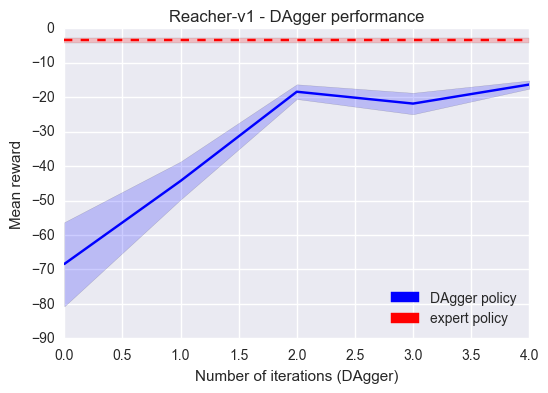

In [9]:
pickle_name = 'data/{}-DAgger-rewards.p'.format(env_name)
returns = pickle.load(open(pickle_name, 'rb'))

their_data = pickle.load(open('data/{}-their.p'.format(env_name), 'rb'))['returns']
their_data = np.array([their_data for _ in range(len(returns.keys()))]).T

df = pd.DataFrame(returns)

sns.tsplot(data=their_data, color='red', linestyle='--')
sns.tsplot(time=df.columns, data=df.values, color='blue', linestyle='-')
plt.ylabel("Mean reward")
plt.xlabel("Number of iterations (DAgger)")
plt.title("{} - DAgger performance".format(env_name))

import matplotlib.patches as mpatches
plt.legend(handles=[
    mpatches.Patch(color='blue', label='DAgger policy'),
    mpatches.Patch(color='red', label='expert policy'),
], loc='lower right')

plt.savefig("dagger-{}.png".format(env_name),format='png')


In [10]:
plt.close()